# Intro

Now that the data has been transformed into a usual, some elementary EDA will be performed to check the numerical features.

In [38]:
import pandas as pd
from os.path import join
from os import listdir
import numpy as np

In [39]:
def read_batches(path):
    """
    Read the batches stored in the path and group them
    :param path: the path with batches
    :return: a pandas dataframe with the grouped and de-duplicated batches
    """
    # Regroup batches
    batches = [pd.read_csv(join(path, f)) for f in listdir(path)]

    # After creating the random observations, potential duplicates (although unlikely) need to be dropped
    observations = pd.concat(batches)
    observations.drop_duplicates(subset=["date", "asset_file"])

    observations.date = pd.to_datetime(observations.date)

    observations.dropna(inplace=True)

    return observations

In [40]:
observations = read_batches("DataBatches")

In [41]:
observations

,asset_file,date,stock,1_month_return,6_month_return,12_month_return,1_month_volatility,6_month_volatility,12_month_volatility,1_month_img,6_month_img,12_month_img,1_month_img_bar,6_month_img_bar,12_month_img_bar,label_1m,1m_return
0,Data/Stocks\ncr.us.txt,2004-04-05,1,0.000439,0.317341,1.388889,0.017516,0.016031,0.023119,Charts/img_500_1_month.PNG,Charts/img_500_6_month.PNG,Charts/img_500_12_month.PNG,Charts/img_500_bar_1_month.PNG,Charts/img_500_bar_6_month.PNG,Charts/img_500_bar_12_month.PNG,0,-0.013871
1,Data/Stocks\chfn.us.txt,2013-05-31,1,-0.001997,0.284303,0.399270,0.004603,0.009990,0.017845,Charts/img_501_1_month.PNG,Charts/img_501_6_month.PNG,Charts/img_501_12_month.PNG,Charts/img_501_bar_1_month.PNG,Charts/img_501_bar_6_month.PNG,Charts/img_501_bar_12_month.PNG,2,0.015084
2,Data/Stocks\tmst.us.txt,2016-01-05,1,-0.151767,-0.657503,-0.770941,0.054340,0.050027,0.039493,Charts/img_502_1_month.PNG,Charts/img_502_6_month.PNG,Charts/img_502_12_month.PNG,Charts/img_502_bar_1_month.PNG,Charts/img_502_bar_6_month.PNG,Charts/img_502_bar_12_month.PNG,0,-0.066185
3,Data/Stocks\gjp.us.txt,2012-08-16,1,-0.053945,-0.075769,0.000470,0.015497,0.013264,0.016023,Charts/img_503_1_month.PNG,Charts/img_503_6_month.PNG,Charts/img_503_12_month.PNG,Charts/img_503_bar_1_month.PNG,Charts/img_503_bar_6_month.PNG,Charts/img_503_bar_12_month.PNG,1,0.001246
4,Data/Stocks\hvt-a.us.txt,2011-09-27,1,-0.104041,-0.224486,-0.056672,0.040486,0.039216,0.033105,Charts/img_504_1_month.PNG,Charts/img_504_6_month.PNG,Charts/img_504_12_month.PNG,Charts/img_504_bar_1_month.PNG,Charts/img_504_bar_6_month.PNG,Charts/img_504_bar_12_month.PNG,2,0.127726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Data/Stocks\sfl.us.txt,2008-01-24,1,-0.157712,-0.122881,0.014062,0.018766,0.024021,0.020691,Charts/img_9495_1_month.PNG,Charts/img_9495_6_month.PNG,Charts/img_9495_12_month.PNG,Charts/img_9495_bar_1_month.PNG,Charts/img_9495_bar_6_month.PNG,Charts/img_9495_bar_12_month.PNG,2,0.104579
496,Data/Stocks\belfa.us.txt,2010-08-18,1,0.201255,0.056782,0.345961,0.051319,0.035508,0.033319,Charts/img_9496_1_month.PNG,Charts/img_9496_6_month.PNG,Charts/img_9496_12_month.PNG,Charts/img_9496_bar_1_month.PNG,Charts/img_9496_bar_6_month.PNG,Charts/img_9496_bar_12_month.PNG,2,0.012205
497,Data/Stocks\evhc.us.txt,2014-09-02,1,0.047564,0.074978,0.393275,0.008937,0.015356,0.017374,Charts/img_9497_1_month.PNG,Charts/img_9497_6_month.PNG,Charts/img_9497_12_month.PNG,Charts/img_9497_bar_1_month.PNG,Charts/img_9497_bar_6_month.PNG,Charts/img_9497_bar_12_month.PNG,0,-0.047149
498,Data/Stocks\snp.us.txt,2010-07-21,1,-0.045617,-0.006414,-0.041886,0.014021,0.017807,0.019190,Charts/img_9498_1_month.PNG,Charts/img_9498_6_month.PNG,Charts/img_9498_12_month.PNG,Charts/img_9498_bar_1_month.PNG,Charts/img_9498_bar_6_month.PNG,Charts/img_9498_bar_12_month.PNG,2,0.040489


## Labels

In [42]:
observations.groupby("label_1m").agg(count=("stock", "count"))

,count
label_1m,
0,8131
1,3059
2,9799


The above distribution of labels is in line with our intuition about equity returns. There are slightly more positive returns (label 2) than negative returns (label 0) and a rather small number of neutral returns (label 1). This imbalance might create problems for the training of a model. Hence, the training sample will need to be balanced.

## Date

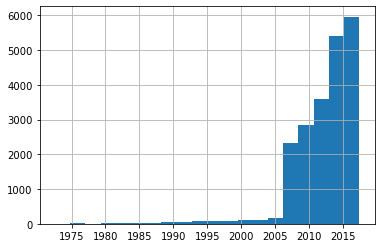

In [43]:
observations.date.hist(bins=20)

From the above histogram, the data appears to be skewed towards more recent dates. This could introduce biases in the model as more recent events are more present in the dataset.

## Returns

In [44]:
observations[["1_month_return", "6_month_return", "12_month_return"]].describe()

,1_month_return,6_month_return,12_month_return
count,20989.000000,20989.000000,20989.000000
mean,0.008963,0.044049,0.089833
std,0.145539,0.429713,0.595435
min,-0.847875,-0.974227,-0.979545
25%,-0.041001,-0.101765,-0.146552
50%,0.004908,0.022643,0.037957
75%,0.050154,0.136464,0.220393
max,8.709302,32.200000,23.400000


From this overview, it appears that there are some extreme returns. For instance 921% returns in the 1 month returns, 515% returns in the 6 month returns, and 2071% returns in the 12 month returns. These outliers could make the trained model less generalizable. To prevent this, returns will be limited to 100% returns. This still corresponds to a 2X return over the period, which is highly unlikely but within reasonable bounds. Returns are also limited on the negative end to -50%, corresponding to a halving of the share price.

In [45]:
observations = observations[
    (observations["1_month_return"] <= 1) &
    (observations["6_month_return"] <= 1) &
    (observations["12_month_return"] <= 1) &
    (observations["1_month_return"] >= -0.5) &
    (observations["6_month_return"] >= -0.5) &
    (observations["12_month_return"] >= -0.5)
].copy()

In [46]:
len(observations.index)

18594

From the original dataset of 9994 observations, 51 were removed leaving us with a dataset of 9943 observations.

## Volatility

In [47]:
# 1 month volatility
observations[["1_month_volatility", "6_month_volatility", "12_month_volatility"]].describe()

,1_month_volatility,6_month_volatility,12_month_volatility
count,18594.000000,18594.000000,18594.000000
mean,0.019793,0.021124,0.063550
std,0.021977,0.018278,5.635772
min,0.000000,0.000071,0.000081
25%,0.009521,0.010999,0.011299
50%,0.015705,0.017517,0.017962
75%,0.025101,0.027124,0.027824
max,2.047381,0.835643,768.485131


Similar to returns, there are some extremely high volatilities, expecially in the 6 and 12 month features. However, these are limited to very few observations and correspond to the remaining observations with very large returns. They are considered acceptable and will not be removed from the dataset.

# Set-up train/validation/test sets

Now the datasets will be split into 50% training, 25% validation, and 25% test sets

In [48]:
import os

observations.drop(
    columns=["asset_file", "date"], # these features will not be taken into account during model training/testing
    inplace=True
)

In [49]:
def balance_sample(classes, data, label_name):
    """
    Create a balanced subset of an unbalanced sample

    :param classes: the prediction classes
    :param data: the dataframe with columns and target classes
    :param label_name: the name of the column with the target
    :param test_size: the size of the test set
    :return: a balanced subset of the unbalanced sample
    """
    data = data.sample(frac=1) # shuffle sample
    data.reset_index(drop=True, inplace=True)
    data["index_flag"] = data.index

    class_sizes = []

    for cl in classes:
        class_sizes.append(len(data[data[label_name] == cl].index))

    min_class_size = np.min(class_sizes)

    samples = []

    for cl in classes:
        t = data[data[label_name] == cl]

        t = t.sample(frac=min_class_size / len(t.index))
        samples.append(t)

    sample = pd.concat(samples)

    return sample

In [50]:
def balanced_sampler(classes, data, label_name, test_size):
    """
    Create a balanced training sample

    :param classes: the prediction classes
    :param data: the dataframe with columns and target classes
    :param label_name: the name of the column with the target
    :param test_size: the size of the test set
    :return: a balanced training sample and a test sample containing the rest
    """
    data = data.sample(frac=1)
    data.reset_index(drop=True, inplace=True)
    data["index_flag"] = data.index

    train_class_size = (1 - test_size) / len(classes)

    train_samples = []

    for cl in classes:
        t = data[data[label_name] == cl]

        t = t.sample(frac=train_class_size * len(data.index) / len(t.index))
        train_samples.append(t)

    train_sample = pd.concat(train_samples)
    test_sample = data[~data.index_flag.isin(list(train_sample.index_flag))].copy()

    # train_sample.drop(columns=["index_flag"], inplace=True)
    # test_sample.drop(columns=["index_flag"], inplace=True)

    return train_sample, test_sample

In [51]:
# Create a subset of the observations that represents a balanced sample between the three classes
balanced_observations = balance_sample([0, 1, 2], observations, label_name="label_1m")

# Create balanced train, test & validation sub-samples
train, temp = balanced_sampler([0, 1, 2], balanced_observations, label_name="label_1m", test_size=0.3)
test, val = balanced_sampler([0, 1, 2], temp, label_name="label_1m", test_size=0.5)

# Create directory
if not os.path.isdir("ModelData"):
    os.makedirs("ModelData")

In [52]:
train.groupby("label_1m").agg(temp=("stock", "count"))

,temp
label_1m,
0,2070
1,2070
2,2070


In [53]:
test.groupby("label_1m").agg(temp=("stock", "count"))

,temp
label_1m,
0,444
1,444
2,444


In [54]:
val.groupby("label_1m").agg(temp=("stock", "count"))

,temp
label_1m,
0,443
1,443
2,443


In [55]:

train.to_csv("ModelData/obs_train.csv", index=False)
val.to_csv("ModelData/obs_val.csv", index=False)
test.to_csv("ModelData/obs_test.csv", index=False)

In [56]:
import pandas as pd

In [57]:
pd.read_csv("ModelData/obs_train.csv")

,stock,1_month_return,6_month_return,12_month_return,1_month_volatility,6_month_volatility,12_month_volatility,1_month_img,6_month_img,12_month_img,1_month_img_bar,6_month_img_bar,12_month_img_bar,label_1m,1m_return,index_flag
0,1,-0.042803,-0.033833,0.140251,0.012012,0.014734,0.013827,Charts/img_15609_1_month.PNG,Charts/img_15609_6_month.PNG,Charts/img_15609_12_month.PNG,Charts/img_15609_bar_1_month.PNG,Charts/img_15609_bar_6_month.PNG,Charts/img_15609_bar_12_month.PNG,0,-0.104347,4392
1,1,0.029743,0.234604,0.039763,0.004988,0.013342,0.013793,Charts/img_10348_1_month.PNG,Charts/img_10348_6_month.PNG,Charts/img_10348_12_month.PNG,Charts/img_10348_bar_1_month.PNG,Charts/img_10348_bar_6_month.PNG,Charts/img_10348_bar_12_month.PNG,0,-0.011246,8775
2,1,0.056484,0.110134,0.185832,0.021896,0.029780,0.038590,Charts/img_4650_1_month.PNG,Charts/img_4650_6_month.PNG,Charts/img_4650_12_month.PNG,Charts/img_4650_bar_1_month.PNG,Charts/img_4650_bar_6_month.PNG,Charts/img_4650_bar_12_month.PNG,0,-0.055722,8343
3,1,-0.063903,0.199115,0.335519,0.022918,0.013827,0.013742,Charts/img_16581_1_month.PNG,Charts/img_16581_6_month.PNG,Charts/img_16581_12_month.PNG,Charts/img_16581_bar_1_month.PNG,Charts/img_16581_bar_6_month.PNG,Charts/img_16581_bar_12_month.PNG,0,-0.068410,6599
4,1,-0.058470,-0.208250,-0.291142,0.030421,0.020003,0.020039,Charts/img_12144_1_month.PNG,Charts/img_12144_6_month.PNG,Charts/img_12144_12_month.PNG,Charts/img_12144_bar_1_month.PNG,Charts/img_12144_bar_6_month.PNG,Charts/img_12144_bar_12_month.PNG,0,-0.032488,3067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6205,1,0.088175,0.196889,0.326502,0.010608,0.021812,0.028337,Charts/img_140_1_month.PNG,Charts/img_140_6_month.PNG,Charts/img_140_12_month.PNG,Charts/img_140_bar_1_month.PNG,Charts/img_140_bar_6_month.PNG,Charts/img_140_bar_12_month.PNG,2,0.061768,7609
6206,1,-0.003149,0.098674,0.584538,0.015820,0.011924,0.018921,Charts/img_13587_1_month.PNG,Charts/img_13587_6_month.PNG,Charts/img_13587_12_month.PNG,Charts/img_13587_bar_1_month.PNG,Charts/img_13587_bar_6_month.PNG,Charts/img_13587_bar_12_month.PNG,2,0.023032,4969
6207,1,-0.026273,0.012148,0.028085,0.022964,0.010876,0.009145,Charts/img_14783_1_month.PNG,Charts/img_14783_6_month.PNG,Charts/img_14783_12_month.PNG,Charts/img_14783_bar_1_month.PNG,Charts/img_14783_bar_6_month.PNG,Charts/img_14783_bar_12_month.PNG,2,0.012016,1047
6208,0,0.102629,-0.305596,-0.231024,0.035395,0.028194,0.026663,Charts/img_14960_1_month.PNG,Charts/img_14960_6_month.PNG,Charts/img_14960_12_month.PNG,Charts/img_14960_bar_1_month.PNG,Charts/img_14960_bar_6_month.PNG,Charts/img_14960_bar_12_month.PNG,2,0.139437,144


In [58]:
pd.read_csv("ModelData/obs_test.csv")

,stock,1_month_return,6_month_return,12_month_return,1_month_volatility,6_month_volatility,12_month_volatility,1_month_img,6_month_img,12_month_img,1_month_img_bar,6_month_img_bar,12_month_img_bar,label_1m,1m_return,index_flag
0,0,-0.012306,-0.084302,-0.268523,0.013506,0.016168,0.014602,Charts/img_7618_1_month.PNG,Charts/img_7618_6_month.PNG,Charts/img_7618_12_month.PNG,Charts/img_7618_bar_1_month.PNG,Charts/img_7618_bar_6_month.PNG,Charts/img_7618_bar_12_month.PNG,0,-0.067602,0
1,1,-0.088112,-0.045388,0.326102,0.015214,0.016151,0.015666,Charts/img_3701_1_month.PNG,Charts/img_3701_6_month.PNG,Charts/img_3701_12_month.PNG,Charts/img_3701_bar_1_month.PNG,Charts/img_3701_bar_6_month.PNG,Charts/img_3701_bar_12_month.PNG,0,-0.076806,1418
2,0,-0.012658,-0.060241,-0.077833,0.002789,0.003249,0.004756,Charts/img_17116_1_month.PNG,Charts/img_17116_6_month.PNG,Charts/img_17116_12_month.PNG,Charts/img_17116_bar_1_month.PNG,Charts/img_17116_bar_6_month.PNG,Charts/img_17116_bar_12_month.PNG,0,-0.013835,1001
3,1,-0.303030,-0.371223,0.790984,0.037030,0.041612,0.047806,Charts/img_14439_1_month.PNG,Charts/img_14439_6_month.PNG,Charts/img_14439_12_month.PNG,Charts/img_14439_bar_1_month.PNG,Charts/img_14439_bar_6_month.PNG,Charts/img_14439_bar_12_month.PNG,0,-0.173469,2057
4,1,0.081347,0.203888,0.821004,0.015006,0.017188,0.017584,Charts/img_9289_1_month.PNG,Charts/img_9289_6_month.PNG,Charts/img_9289_12_month.PNG,Charts/img_9289_bar_1_month.PNG,Charts/img_9289_bar_6_month.PNG,Charts/img_9289_bar_12_month.PNG,0,-0.107517,991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,0,0.031311,-0.052792,0.006433,0.015632,0.035893,0.027604,Charts/img_4957_1_month.PNG,Charts/img_4957_6_month.PNG,Charts/img_4957_12_month.PNG,Charts/img_4957_bar_1_month.PNG,Charts/img_4957_bar_6_month.PNG,Charts/img_4957_bar_12_month.PNG,2,0.042066,772
1328,0,0.033799,-0.080392,0.250667,0.016148,0.016633,0.015454,Charts/img_486_1_month.PNG,Charts/img_486_6_month.PNG,Charts/img_486_12_month.PNG,Charts/img_486_bar_1_month.PNG,Charts/img_486_bar_6_month.PNG,Charts/img_486_bar_12_month.PNG,2,0.025265,1432
1329,1,0.004049,0.130018,0.255618,0.011868,0.013561,0.016331,Charts/img_8947_1_month.PNG,Charts/img_8947_6_month.PNG,Charts/img_8947_12_month.PNG,Charts/img_8947_bar_1_month.PNG,Charts/img_8947_bar_6_month.PNG,Charts/img_8947_bar_12_month.PNG,2,0.044350,521
1330,1,0.016754,0.007798,0.395521,0.011079,0.017375,0.017274,Charts/img_11066_1_month.PNG,Charts/img_11066_6_month.PNG,Charts/img_11066_12_month.PNG,Charts/img_11066_bar_1_month.PNG,Charts/img_11066_bar_6_month.PNG,Charts/img_11066_bar_12_month.PNG,2,0.073949,1581
